# 1. Подготовка

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
#!jupyter nbextension enable --py widgetsnbextension
import catboost
from catboost import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install -U scikit-learn --user
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv("/datasets/taxi.csv", parse_dates=[0] , index_col = [0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [5]:
df = df.resample("1H").sum()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


# 2. Анализ

In [7]:
#Заранее разметим тест и трейн выборки
df['data_type'] = 'train'
df['data_type'].loc[int(df.shape[0]*0.9):] = "test"
print(df['data_type'].value_counts())

test_values = df.query('data_type == "test"').copy() #спрячем тест и удалим его из дата сета

### Надосделать так что бы данные полученные из целевого признака test 
#не использовались при предсказании
df['num_orders'].loc[df['data_type'] == "test"] = np.nan

train    3974
test      442
Name: data_type, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Комментарий ревьюера
Несколько своеобразное деление на тест и трейн, более того, на этапе анализа в этом нет необходимости, скорее наоборот – нужно посмотреть на *все* данные и убедиться, что тестовая выборка, в частности, «похожа» на тренировочную и обучение моделей вообще осмысленно. 

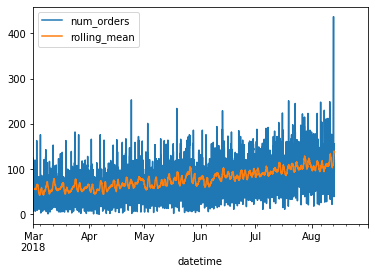

In [8]:
df['rolling_mean'] = df.rolling(24).mean()
df.plot()
df = df.drop('rolling_mean', axis = 1)

In [9]:
#тренды и сезонность
df = df.fillna(0)
decomposed = seasonal_decompose(df['num_orders'])

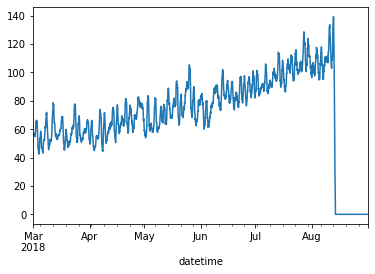

In [10]:
decomposed.trend.plot()

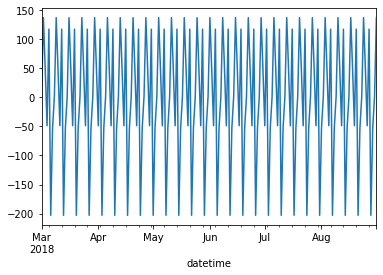

In [11]:
# сезонность заметна только на днях
df2 = df.resample("1D").sum()
decomposed2 = seasonal_decompose(df2['num_orders'])
decomposed2.seasonal.plot()

# 3. Обучение

In [12]:
#Мы будем предсказывать 10% тестовых значений не используя тестовый целевой признак в предсказаниях.
#(потому что использывать целевой признак для его же предсказания как в тренажере это бред)
# для начала попробуем просто бустинг

##Я имел ввиду что в тренажере предсказывается сразу вея выборка одной моделью обученной во многом на лагах с этой же тестовой выборки.

In [13]:
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour']=df.index.hour
df = df.reset_index()

In [14]:
test = df.loc[df['data_type']=='test']
train = df.loc[df['data_type']=='train']

In [15]:
test_features = test.drop(["num_orders",'data_type'],axis = 1)
test_target = test_values["num_orders"] #не зря сохраняли

In [16]:
#нужно создать валидационную выборку для градиентного бустинга

train,valid = train_test_split(train, test_size = 0.1,shuffle = False )
train_features = train.drop(["num_orders",'data_type'],axis = 1)
train_target = train["num_orders"]

valid_features = valid.drop(["num_orders",'data_type'],axis = 1)
valid_target = valid["num_orders"]

In [17]:
cat_features = ['month','day','weekday','hour' ]
Catmodel = CatBoostRegressor(
    iterations=10000,
    random_seed=63,
    learning_rate=0.01,
    early_stopping_rounds=300,
    loss_function='RMSE'
)
Catmodel.fit(
    train_features, train_target,
    cat_features=cat_features,
    eval_set=(valid_features, valid_target),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
#тестируем модель.
prediction = Catmodel.predict(test_features)
print("RMSE:",(mean_squared_error(prediction,test_target)**0.5))
# RMSE: 44.44025390915556 мы уже добились нужного результата не использовав ничего кроме даты

#если временные параметры указывать как категориальные признаки качество немного лучше
#RMSE: 39.7881239529497

#еще у Catboost оказался какойто встроенный обработчик времянных рядов и он хорошо использывал datetime как еще одну фичу

#не понимаю почему вдруг упал рмсе. раньше с точно такими же парамтерами давал не больше 46!? Может в алгоритме катбуста что-то обновили на днях

RMSE: 58.928070797407216


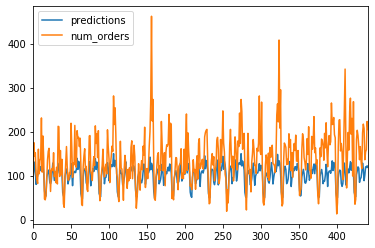

In [19]:
take_a_look = test_target.copy()
take_a_look = take_a_look.reset_index()
take_a_look = pd.DataFrame(take_a_look).merge(pd.Series(data =prediction, name = 'predictions'), left_index=True,right_index=True)
take_a_look['predictions'].plot(legend = True)
take_a_look['num_orders'].plot(legend = True)

# мы видим что наше предсказание не учитывает общий медленный тренд возрастания
# проигрывает на больших выпадах и вроде занижает нижние значения

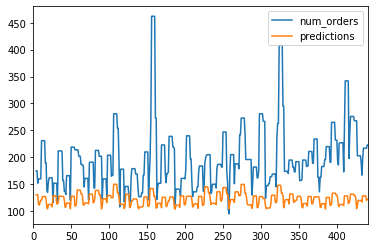

In [20]:
take_a_look.rolling(5).max().plot()

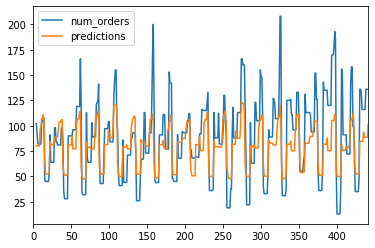

In [21]:
take_a_look.rolling(5).min().plot()

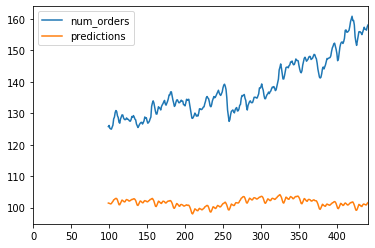

In [22]:
take_a_look.rolling(100).mean().plot()

# мы видим что наше предсказание не учитывает общий медленный тренд возрастания
# проигрывает на больших выпадах

In [162]:
# теперь попробуем используя шифт и ролинг, возможно это поправит ситуацию

In [23]:
df.query('data_type == "test" ') # 3974 - 4415
df2 = df.drop('data_type', axis = 1)

In [24]:
df2 = df2.drop('datetime',axis = 1)


In [25]:
def make_features(df , target, lag_range):

    for lag in lag_range:
        df['lag_{}'.format(lag,target)] = df[target].shift(lag)
        

In [26]:

#функция предсказывает по одному значения и заново обучается на каждем шаге

def step_by_step(df,target_column,target_range, model,lag_range,rolling_value,speak = True,save = False):
    result = df.copy()
    for i in target_range:
        make_features(result , target_column, lag_range)
        #result['rolling_mean'] = result.loc[0:i,target_column].rolling(rolling_value).mean()
        train_df = result.loc[max(lag_range[-1], rolling_value):(i-1)]
        model.fit(train_df.drop([target_column],axis=1),train_df[target_column])
        one_prediction = model.predict(result.loc[i].drop(target_column).values.reshape(1, -1))
        result.loc[i, target_column] = one_prediction
        if speak == True:
            print(i, " значение  предсказано, показатель: ",one_prediction )
        if save == True:
            result.to_csv("save_result.csv")
            print('файл сохранен')
 
    print("RMSE:",(mean_squared_error(result.loc[target_range,target_column],test_target[:len(target_range)])**0.5))
    return result      

In [93]:
#оказалось что rolling почему-то полностью портит всю модель, пока запустим без него

first_try = step_by_step(df=df2,target_column="num_orders",
             target_range= range(3974,4416), 
             model=LinearRegression(),lag_range=range(1,500),rolling_value=5)
#RMSE: 62.84132139132774 на 24 лагах

# RMSE: RMSE: 41.92263365336792 лучшее рмсе на 500 лагах (правда больше не стал пробывать)
# но это потому что слабая модель простая LiearRegression.

3974  значение  предсказано, показатель:  [123.98386008]
3975  значение  предсказано, показатель:  [119.25601224]
3976  значение  предсказано, показатель:  [154.41992229]
3977  значение  предсказано, показатель:  [149.19841421]
3978  значение  предсказано, показатель:  [79.34603679]
3979  значение  предсказано, показатель:  [112.46221937]
3980  значение  предсказано, показатель:  [95.19743567]
3981  значение  предсказано, показатель:  [135.16795881]
3982  значение  предсказано, показатель:  [100.24809285]
3983  значение  предсказано, показатель:  [125.20751533]
3984  значение  предсказано, показатель:  [164.0029231]
3985  значение  предсказано, показатель:  [152.8788952]
3986  значение  предсказано, показатель:  [164.5349929]
3987  значение  предсказано, показатель:  [141.11077973]
3988  значение  предсказано, показатель:  [137.99449633]
3989  значение  предсказано, показатель:  [76.94957263]
3990  значение  предсказано, показатель:  [56.61244241]
3991  значение  предсказано, показател

In [33]:
take_a_look2 = test_target.copy()
take_a_look2 = take_a_look2.reset_index()
results2 = first_try.loc[3974:4416, "num_orders"].reset_index()
take_a_look2 = take_a_look2.merge(results2, left_index=True,right_index=True)
take_a_look2 = take_a_look2.drop('index',axis =1)

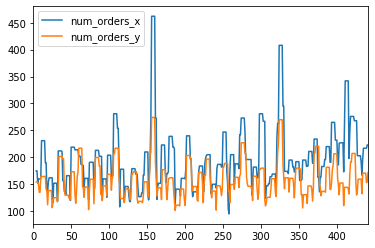

In [35]:
take_a_look2.rolling(5).max().plot()
#снова непопадание в общий тренд
# зато эта модель не выглядит слишком переученной

In [481]:
#попробуем тоже самое только модель посильнее

from sklearn.ensemble import RandomForestRegressor
secound_try = step_by_step(df=df2,target_column="num_orders",
             target_range= range(3974,4416), 
             model=RandomForestRegressor(),lag_range=range(1,50),rolling_value=5)

#RMSE: 54.61461028066205 а считала часа 3.

3974  значение  предсказано, показатель:  [110.43]
3975  значение  предсказано, показатель:  [139.41]
3976  значение  предсказано, показатель:  [158.74]
3977  значение  предсказано, показатель:  [141.52]
3978  значение  предсказано, показатель:  [84.84]
3979  значение  предсказано, показатель:  [100.01]
3980  значение  предсказано, показатель:  [99.7]
3981  значение  предсказано, показатель:  [112.18]
3982  значение  предсказано, показатель:  [119.37]
3983  значение  предсказано, показатель:  [146.44]
3984  значение  предсказано, показатель:  [175.85]
3985  значение  предсказано, показатель:  [150.38]
3986  значение  предсказано, показатель:  [156.65]
3987  значение  предсказано, показатель:  [142.96]
3988  значение  предсказано, показатель:  [124.43]
3989  значение  предсказано, показатель:  [77.77]
3990  значение  предсказано, показатель:  [52.79]
3991  значение  предсказано, показатель:  [42.99]
3992  значение  предсказано, показатель:  [91.9]
3993  значение  предсказано, показатель

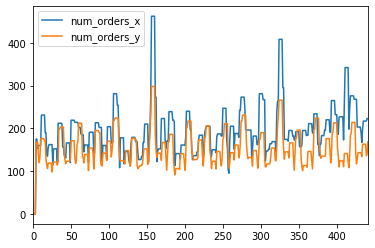

In [483]:
take_a_look3 = test_target.copy()
take_a_look3 = take_a_look3.reset_index()
results3 = secound_try.loc[3974:4416, "num_orders"].reset_index()
take_a_look3 = take_a_look3.merge(results2, left_index=True,right_index=True)
take_a_look3 = take_a_look3.drop('index',axis =1)
take_a_look3.rolling(5).max().plot()
#снова непопадание в общий тренд

#вобщем на всех графиках примерно одинаковая ошибка занижения из-за игнорирования тренда.

будем думать как учитывать тренд при прогнозе

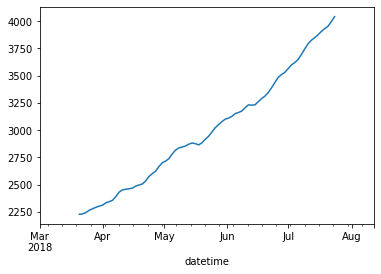

In [100]:
df2 = df.query('data_type == "train"')
df2 = df2.set_index('datetime')

df2 = df2.resample("39H").sum()
decomposed2 = seasonal_decompose(df2['num_orders'])
decomposed2.trend.plot()

#мы видим что с апреля по июнь идет рост, в июле-августе идет глобальное падение спроса.
#У нас данные только за пол года
#и поэтому мы не можем просчитать, то что сезонно в сентябре идет снова подъем

#поэтому модели и ошибаются.

#искуствененно рисовать тренд вверх в сентябре будет не совсем честно, 
#выйдет что мы подгоняем обучение под прогнозы

поправил, была ошибка в коде из-за которйо попали нули на гарфик

### Предсказание тренда

Попробуем найти значение при помощи функции

In [140]:
df4 = df.loc[:3969] #срежем хвостик что бы делить на ровные отрезки

In [141]:
df4['X'] = 1
df4 = df4.set_index('datetime')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
df4 = df4.resample("397H").sum()

In [143]:
df4['X'] = df4['X'].cumsum()

In [144]:
df4 = df4[["num_orders", 'X']]
df4

,num_orders,X
datetime,,
2018-03-01 00:00:00,22695.0,397
2018-03-17 13:00:00,22924.0,794
2018-04-03 02:00:00,23693.0,1191
2018-04-19 15:00:00,27319.0,1588
2018-05-06 04:00:00,28864.0,1985
2018-05-22 17:00:00,30809.0,2382
2018-06-08 06:00:00,33734.0,2779
2018-06-24 19:00:00,36190.0,3176
2018-07-11 08:00:00,40521.0,3573


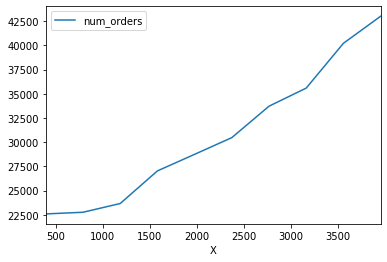

In [139]:
df4.plot(x = "X", y = "num_orders") #эт мы вроде сделали аппроксимацию

#делаем линейную экспрополяцию по двум послденим точкам и получаем что в точке 4416 
#(конец тестовой выборки) Y должен быть = 47625

делаем линейную экспрополяцию по двум послденим точкам и получаем что в точке 4416 
(конец тестовой выборки) Y должен быть = 47625.
значит в среднем рост на 8.4 за час. Итого получаем такую функцию которая будет корректировать наш итоговый подсчет:

In [152]:
def corrector(prediction, number = 8.4):
    result = []
    step = number / len(prediction)
    for i in range(len(prediction)):
        result.append((prediction[i]+(step*i))*2)
    return result
    

In [147]:
#конец предсказания тренда, продолжение.
#продолжение

#мы выяснили что лучше всего работает градиентный бустинг, 
#а так же метод дополнения параметров по одному
#попробуем совместить

#чуть подкорректируем старую функцию под бустинг
#все же обучать ее мы каждй раз не будем(слишком долго), а один раз обучим
#и потом сделаем предсказания на предсказаниях
def step_by_step2(df,target_column,target_range, model,lag_range,cat_feat):
    result = df.copy()
    make_features(result , target_column, lag_range)
    train_df = result.loc[lag_range[-1]:3973]
    train,valid = train_test_split(train_df, test_size = 0.1,shuffle = False )
    train_features = train.drop(["num_orders",'data_type', 'datetime'],axis = 1)
    train_target = train["num_orders"]
    valid_features = valid.drop(["num_orders",'data_type','datetime'],axis = 1)
    valid_target = valid["num_orders"]
    model = model
    model.fit(train_features,train_target,cat_features=cat_feat,eval_set=(valid_features, valid_target),verbose=False)
    for i in target_range:
        one_prediction = model.predict(result.loc[i].drop(["num_orders",'data_type', 'datetime']).values.reshape(1, -1))
        result.loc[i, target_column] = one_prediction
        print(i, " значение  предсказано, показатель: ",one_prediction)
    print("RMSE:",(mean_squared_error(result.loc[target_range,target_column],test_target)**0.5))
    return result  

In [148]:
%%time
#кстати теперь datetime не принимает и ругается.
last_try = step_by_step2(df=df,target_column="num_orders",target_range= range(3974,4416),model= CatBoostRegressor(iterations=5000,random_seed=63,learning_rate=0.01,early_stopping_rounds=100,loss_function='RMSE'),lag_range=range(1,500), cat_feat =['month','day','weekday','hour'])

#RMSE: 87.29268713502869, такое нам не подходит), а обучать ГБ модель на каждой итерации слишком долго

3974  значение  предсказано, показатель:  [100.57813358]
3975  значение  предсказано, показатель:  [117.18252923]
3976  значение  предсказано, показатель:  [149.61010654]
3977  значение  предсказано, показатель:  [131.94597117]
3978  значение  предсказано, показатель:  [85.77763349]
3979  значение  предсказано, показатель:  [108.3734601]
3980  значение  предсказано, показатель:  [88.13759612]
3981  значение  предсказано, показатель:  [118.6869487]
3982  значение  предсказано, показатель:  [109.77996848]
3983  значение  предсказано, показатель:  [123.67499603]
3984  значение  предсказано, показатель:  [147.15951991]
3985  значение  предсказано, показатель:  [112.57523518]
3986  значение  предсказано, показатель:  [132.86166609]
3987  значение  предсказано, показатель:  [120.62879616]
3988  значение  предсказано, показатель:  [118.07254286]
3989  значение  предсказано, показатель:  [60.10410658]
3990  значение  предсказано, показатель:  [49.36382404]
3991  значение  предсказано, показате

### 3.5 Подбор гиперпарамтеров

Наша модель простая liearregression не имеет гиперпараметров (кроме normalized, которая в данном случае ничего не изменит).
У нас появился параметр lag_range - количество лагов, оптимизируем сначала его.

In [116]:
for i in range(200,1000,50):
    print('Начинаем предсказание lag_range =', i )
    final = step_by_step(df=df2,target_column="num_orders",
             target_range= range(3974,4416), 
             model=LinearRegression(),lag_range=range(1,i),rolling_value=5,speak = False)
#добавил еще в функцию speak что бы выводил только итоговый рмсе, а не каждую итерацию.


#Начинаем предсказание lag_range = 750
#RMSE: 40.094773299516895
#таким образом лучшее количество лагов - примерно 750.
    

Начинаем предсказание lag_range = 200
RMSE: 44.73957340418811
Начинаем предсказание lag_range = 250
RMSE: 44.927249513289475
Начинаем предсказание lag_range = 300
RMSE: 44.90796015812164
Начинаем предсказание lag_range = 350
RMSE: 42.74514106954077
Начинаем предсказание lag_range = 400
RMSE: 42.67335422025916
Начинаем предсказание lag_range = 450
RMSE: 42.281922348886575
Начинаем предсказание lag_range = 500
RMSE: 41.92263365336792
Начинаем предсказание lag_range = 550
RMSE: 41.82584119636612
Начинаем предсказание lag_range = 600
RMSE: 41.80844650170172
Начинаем предсказание lag_range = 650
RMSE: 41.11905211925035
Начинаем предсказание lag_range = 700
RMSE: 40.49365777350542
Начинаем предсказание lag_range = 750
RMSE: 40.094773299516895
Начинаем предсказание lag_range = 800
RMSE: 40.357962374945096
Начинаем предсказание lag_range = 850
RMSE: 40.528559761466724
Начинаем предсказание lag_range = 900
RMSE: 40.522834125104886
Начинаем предсказание lag_range = 950
RMSE: 40.83972877343296


In [122]:
#тогда подберем более-менее оптимальные параметры для RandomForestRegression

#сперва подберем глубину 

#это займет вечность, поэтому будем подбирать не по всей выборке, а только по 30 первым значениям
#поэтмоу вместо всей выборки range(3974,4416) будем подбиратьтолько по range(3974,4010)
# это конечно даст не совсем верный и завышенный результат, 
#но позволит в реальный срок в целом оценить гиперпараметры


from sklearn.ensemble import RandomForestRegressor
for i in range(1,40,4):
    print('Начинаем расчет для глубины:', i)
    hyper_depth_try = step_by_step(df=df2,target_column="num_orders",target_range= range(3974,4010), 
            model=RandomForestRegressor(n_estimators=3, max_depth=i, random_state=12345),lag_range=range(1,750),rolling_value=5,speak = False)
    
#лучшая глубина между 1 и 9, но возможно параметр по умолчанию будет лучше

Начинаем расчет для глубины: 1
RMSE: 45.14357754140469
Начинаем расчет для глубины: 5
RMSE: 34.14430371429069
Начинаем расчет для глубины: 9
RMSE: 37.9326284684638
Начинаем расчет для глубины: 13
RMSE: 34.57711415988556
Начинаем расчет для глубины: 17
RMSE: 36.99661152411849
Начинаем расчет для глубины: 21
RMSE: 37.32162882367443
Начинаем расчет для глубины: 25
RMSE: 37.77161351305995
Начинаем расчет для глубины: 29
RMSE: 38.20506361917756
Начинаем расчет для глубины: 33
RMSE: 38.20506361917756
Начинаем расчет для глубины: 37
RMSE: 38.20506361917756


In [123]:
#ищем с 2-9 и проверям по умолчанию
for i in range(2,9,2):
    print('Начинаем расчет для глубины:', i)
    hyper_depth_try = step_by_step(df=df2,target_column="num_orders",target_range= range(3974,4010), 
            model=RandomForestRegressor(n_estimators=3, max_depth=i, random_state=12345),lag_range=range(1,750),rolling_value=5,speak = False)
    
print('Проверяем значение без заданного параметра')
step_by_step(df=df2,target_column="num_orders",target_range= range(3974,4010), 
            model=RandomForestRegressor(n_estimators=3, random_state=12345),lag_range=range(1,750),rolling_value=5,speak = False)

#Начинаем расчет для глубины: 8
#RMSE: 33.35622510414932
#лучшая глубина - 8.

Начинаем расчет для глубины: 2
RMSE: 40.573732648015806
Начинаем расчет для глубины: 4
RMSE: 34.99306987340541
Начинаем расчет для глубины: 6
RMSE: 35.46487596124368
Начинаем расчет для глубины: 8
RMSE: 33.35622510414932
Проверяем значение без заданного параметра
RMSE: 38.20506361917756


,num_orders,month,day,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_740,lag_741,lag_742,lag_743,lag_744,lag_745,lag_746,lag_747,lag_748,lag_749
0,124.0,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85.0,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.0,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,66.0,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43.0,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,0.0,8,31,4,19,0.0,0.0,0.0,0.0,0.0,...,125.0,124.0,131.0,98.0,85.0,42.0,112.0,100.0,99.0,75.0
4412,0.0,8,31,4,20,0.0,0.0,0.0,0.0,0.0,...,182.0,125.0,124.0,131.0,98.0,85.0,42.0,112.0,100.0,99.0
4413,0.0,8,31,4,21,0.0,0.0,0.0,0.0,0.0,...,98.0,182.0,125.0,124.0,131.0,98.0,85.0,42.0,112.0,100.0
4414,0.0,8,31,4,22,0.0,0.0,0.0,0.0,0.0,...,133.0,98.0,182.0,125.0,124.0,131.0,98.0,85.0,42.0,112.0


In [ ]:
#теперь ищем оптмальное количество n_estimators
for i in range(30,200,20):
    print('Начинаем расчет для n_estimators=:', i)
    hyper_depth_try = step_by_step(df=df2,target_column="num_orders",target_range= range(3974,4010), 
            model=RandomForestRegressor(n_estimators=i, max_depth=8, random_state=12345),lag_range=range(1,750),rolling_value=5,speak = False)

    
#Начинаем расчет для n_estimators=: 30
#RMSE: 33.17939356534809
#Начинаем расчет для n_estimators=: 50
#RMSE: 33.1545722894312
#Начинаем расчет для n_estimators=: 70
#RMSE: 32.618387961144656
#Начинаем расчет для n_estimators=: 90
#RMSE: 32.48326142664423
#Начинаем расчет для n_estimators=: 110
#RMSE: 32.9402343631586
#Начинаем расчет для n_estimators=: 130
#RMSE: 32.92136375653972

#в общем оптимально примерно 100, правда это будет предсказывать часов 10

Начинаем расчет для n_estimators=: 30
RMSE: 33.17939356534809
Начинаем расчет для n_estimators=: 50
RMSE: 33.1545722894312
Начинаем расчет для n_estimators=: 70
RMSE: 32.618387961144656
Начинаем расчет для n_estimators=: 90
RMSE: 32.48326142664423
Начинаем расчет для n_estimators=: 110
RMSE: 32.9402343631586
Начинаем расчет для n_estimators=: 130
RMSE: 32.92136375653972
Начинаем расчет для n_estimators=: 150


In [1]:
#Мы выяснили что лучше всего (качество/время)
#с нашей задачей справляется гаридентный бустинг 
#и последовательные регрессии

#итоговые гиперпараметры: глубина 8, количество лагов 750, деревьев 100.

In [25]:
 final_try = step_by_step(df=df2,target_column="num_orders",target_range= range(3974,4416), 
            model=RandomForestRegressor(n_estimators=100, max_depth=8, random_state=12345),lag_range=range(1,750),speak = True,save = True, rolling_value=1)
    
#добавил параметр save что бы сохранять файл каждую итерацию на случай падения

#спустя 12 часов подсчетов мы получили RMSE: 42.64827805831584
#что хуже чем у обычной линейной регрессии с 750 лагами RMSE: 40.094773299516895

3974  значение  предсказано, показатель:  [91.23970397]
файл сохранен
3975  значение  предсказано, показатель:  [116.98780627]
файл сохранен
3976  значение  предсказано, показатель:  [150.91824705]
файл сохранен
3977  значение  предсказано, показатель:  [147.89454405]
файл сохранен
3978  значение  предсказано, показатель:  [83.67798743]
файл сохранен
3979  значение  предсказано, показатель:  [114.03067146]
файл сохранен
3980  значение  предсказано, показатель:  [91.65753059]
файл сохранен
3981  значение  предсказано, показатель:  [120.15238744]
файл сохранен
3982  значение  предсказано, показатель:  [114.8031165]
файл сохранен
3983  значение  предсказано, показатель:  [120.44890424]
файл сохранен
3984  значение  предсказано, показатель:  [176.15019325]
файл сохранен
3985  значение  предсказано, показатель:  [141.60418582]
файл сохранен
3986  значение  предсказано, показатель:  [143.12747647]
файл сохранен
3987  значение  предсказано, показатель:  [127.9282972]
файл сохранен
3988  значе


По всей видимости подбор гиперпарамтеров по первым 50числам работает не очень хорошо, а так же
по хорошему нужно перебирать все сочетания гиперпарамтеров, но на это уйдут месяцы.
В итоге лучшая модель это проста регрессия с 750 лагами.

# 4. Тестирование

In [27]:
very_final = step_by_step(df=df2,target_column="num_orders",
             target_range= range(3974,4416), 
             model=LinearRegression(),lag_range=range(1,750),rolling_value=5,speak = False)

RMSE: 40.094773299516895


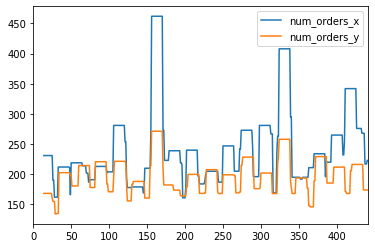

In [28]:
#RMSE: 40.094773299516895

last_look = test_target.copy()
last_look = last_look.reset_index()
results4 = very_final.loc[3974:4416, "num_orders"].reset_index()
last_look = last_look.merge(results4, left_index=True,right_index=True)
last_look = last_look.drop('index',axis =1)
last_look.rolling(15).max().plot()

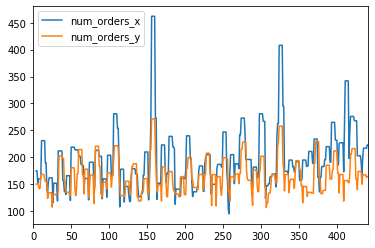

In [35]:
last_look.rolling(5).max().plot()

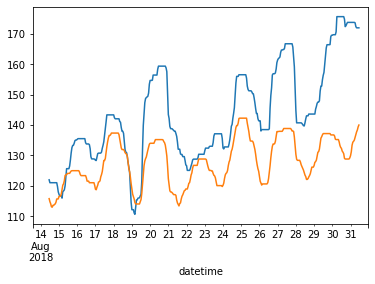

In [46]:
#last_look = last_look.set_index('datetime')
decomposed3 = seasonal_decompose(last_look['num_orders_x'])
decomposed4 = seasonal_decompose(last_look['num_orders_y'])
decomposed3.trend.rolling(10).max().plot()
decomposed4.trend.rolling(10).max().plot()

In [166]:
last_prediction = last_look['num_orders_y'].tolist()

In [167]:
corrected_prediction = corrector(last_prediction)

In [168]:
last_look['corrected_pred'] = corrected_prediction

RMSE после корректировки 38.33979471264851


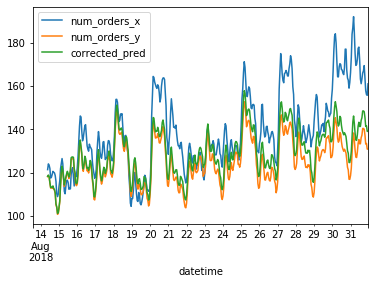

In [171]:
last_look.rolling(20).mean().plot()

print("RMSE после корректировки", mean_squared_error(last_look['num_orders_x'],last_look['corrected_pred'])**0.5)

Уже лучше. Но видимо шаг в 8.4 был расчитан не правильно, либо в реальности рост был быстрее. Можно подогнать цифры и задать его побольше. (хотя это читерство)

In [187]:
corrected_prediction2 = corrector(last_prediction, number = 28)

RMSE после второй корректировки 36.48379377943706


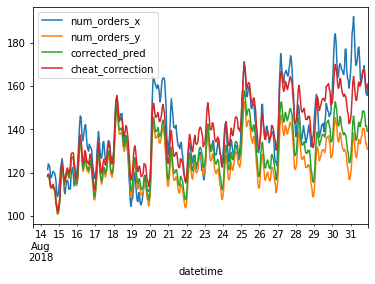

In [188]:
last_look['cheat_correction'] = corrected_prediction2
last_look.rolling(20).mean().plot()
print("RMSE после второй корректировки", mean_squared_error(last_look['num_orders_x'],last_look['cheat_correction'])**0.5)

Мы предсказали заказы такси с  RMSE: 40.094773299516895, ошибка связана с тем что у нас недостаточно
данных для предсказания сезонного повышения спроса в сентябре.

При помощи корректирующей функции можем поднять его до 38.3-36.4